In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [2]:
use_cuda = True
device = torch.device('cuda:4' if use_cuda else 'cpu')

# 1、Load data

In [3]:
dataMNIST_train = dsets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
       ])
)
dataMNIST_test = dsets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
       ])
)

In [4]:
dataLoaderMNIST_train = torch.utils.data.DataLoader(
    dataset = dataMNIST_train,
    batch_size = 128,
    shuffle = True,
)
dataLoaderMNIST_test = torch.utils.data.DataLoader(
    dataset = dataMNIST_test,
    batch_size = 128,
    shuffle = True,
)

In [5]:
x,y = iter(dataLoaderMNIST_train).next()

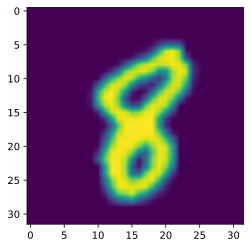

In [6]:
plt.imshow(x[0][0],interpolation = 'bilinear')

# 2、model

In [50]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            #(32,32)
            nn.Conv2d(1,16,3,stride = 2,padding = 1),#(16,16)
            nn.ReLU(),
            nn.Conv2d(16,32,3,stride = 2,padding = 1),#(8,8)
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride = 2,padding = 1),#(4,4)
            nn.ReLU(),
            nn.Conv2d(64,128,3,stride = 2,padding = 1),#(2,2)
            nn.ReLU(),
            nn.Conv2d(128,256,3,stride = 2,padding = 1),#(1,1)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256,12),
            nn.Sigmoid(),
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(12,256),
            nn.ReLU(),
            nn.Unflatten(1,(256,1,1)),
            #(1,1)
            nn.ConvTranspose2d(256,128,4,stride = 2,padding = 1),#(2,2)
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,stride = 2,padding = 1),#(4,4)
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,stride = 2,padding = 1),#(8,8)
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,4,stride = 2,padding = 1),#(16,16)
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,4,stride = 2,padding = 1),#(32,32)
            nn.ReLU(),
        )
        
    def forward(self,x):
#         x.cu
        code = self.encoder(x)
        y = self.decoder(code)
        return y,code

In [51]:
ae = AE()
ae.to(device)
x,y = iter(dataLoaderMNIST_train).next()
y_,code = ae(x.cuda(device))
y_[0][0]

tensor([[2.6711e-02, 8.8450e-02, 1.7067e-02,  ..., 8.8175e-02, 1.6409e-02,
         7.9240e-02],
        [4.8394e-02, 1.1863e-01, 1.0991e-02,  ..., 1.1994e-01, 1.5477e-02,
         3.5871e-02],
        [2.7178e-02, 5.5427e-02, 0.0000e+00,  ..., 5.3884e-02, 0.0000e+00,
         5.1535e-02],
        ...,
        [4.6817e-02, 1.1670e-01, 1.0352e-02,  ..., 1.2016e-01, 1.6120e-02,
         3.6436e-02],
        [2.7049e-02, 5.4896e-02, 1.9923e-05,  ..., 5.0607e-02, 0.0000e+00,
         5.3703e-02],
        [7.1894e-02, 1.0049e-01, 6.9036e-02,  ..., 1.0037e-01, 7.1062e-02,
         3.3242e-02]], device='cuda:4', grad_fn=<SelectBackward>)

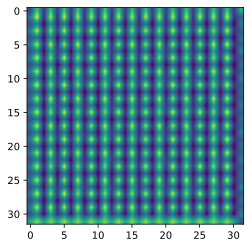

In [52]:
plt.imshow(y_[0][0].cpu().detach().numpy(),interpolation = 'bilinear')

In [53]:
optimizer = optim.Adam(ae.parameters(),lr = 0.001)
loss_func1 = nn.MSELoss()

In [54]:
ae.train()
for i in range(5):
    for step,(x,y) in enumerate(dataLoaderMNIST_train):
        x = x.cuda(device)
#         y = F.one_hot(y).type_as(x).cuda(device)
        y_,code = ae(x)
        loss = loss_func1(y_,x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('\r epoch:{epoch:3}--step:{step:5}--loss:{loss:.7f}'.format(epoch=i,step=step,loss=loss),end='')
    print()

 epoch:  0--step:  468--loss:0.0299985
 epoch:  1--step:  468--loss:0.0171046
 epoch:  2--step:  468--loss:0.0140752
 epoch:  3--step:  468--loss:0.0110389
 epoch:  4--step:  468--loss:0.0096382


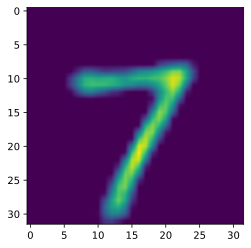

In [55]:
plt.imshow(y_[0][0].cpu().detach().numpy(),interpolation = 'bilinear')

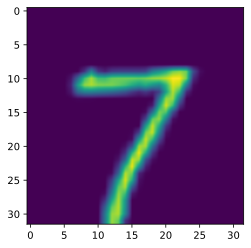

In [56]:
plt.imshow(x[0][0].cpu().detach().numpy(),interpolation = 'bilinear')

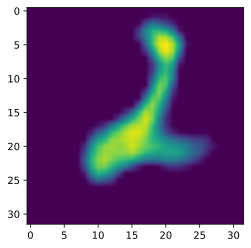

In [73]:
s = torch.rand(1,12).cuda(device)
y_ = ae.decoder(s)
plt.imshow(y_[0][0].cpu().detach().numpy(),interpolation = 'bilinear')

In [172]:
class AE1(nn.Module):
    def __init__(self):
        super(AE1, self).__init__()
        self.encoder = nn.Sequential(
            #(32,32)
            nn.Conv2d(1,16,3,stride = 2,padding = 1),#(16,16)
            nn.ReLU(),
            nn.Conv2d(16,32,3,stride = 2,padding = 1),#(8,8)
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride = 2,padding = 1),#(4,4)
            nn.ReLU(),
            nn.Conv2d(64,128,3,stride = 2,padding = 1),#(2,2)
            nn.ReLU(),
            nn.Conv2d(128,256,3,stride = 2,padding = 1),#(1,1)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256,12),
            nn.ReLU(),
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(10,10),
            nn.Softmax(),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2,2),
            nn.Sigmoid(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(12,256),
            nn.ReLU(),
            nn.Unflatten(1,(256,1,1)),
            #(1,1)
            nn.ConvTranspose2d(256,128,4,stride = 2,padding = 1),#(2,2)
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,stride = 2,padding = 1),#(4,4)
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,stride = 2,padding = 1),#(8,8)
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,4,stride = 2,padding = 1),#(16,16)
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,4,stride = 2,padding = 1),#(32,32)
            nn.ReLU(),
        )
        
    def forward(self,x,y):
        GT = F.one_hot(y).type_as(x)
        
        code = self.encoder(x)
        clss = self.fc1(code[:,:10])
        feature = self.fc2(code[:,10:])
        
        x1 = torch.hstack((GT,feature))
        y = self.decoder(x1)
        return y,clss,feature

In [232]:
ae1 = AE1()
ae1.to(device)
optimizer1 = optim.Adam(ae1.encoder.parameters(),lr = 0.001)
optimizer2 = optim.Adam(ae1.decoder.parameters(),lr = 0.001)
loss_func1 = nn.MSELoss()
loss_func2 = nn.CrossEntropyLoss()
x,y = iter(dataLoaderMNIST_train).next()
y_,clss,feature = ae1(x.cuda(device),y.cuda(device))
y_[0][0]

tensor([[0.1772, 0.1421, 0.1817,  ..., 0.1412, 0.1815, 0.1810],
        [0.1976, 0.1783, 0.1945,  ..., 0.1772, 0.1943, 0.2353],
        [0.1890, 0.1315, 0.2196,  ..., 0.1311, 0.2176, 0.1951],
        ...,
        [0.1991, 0.1819, 0.1913,  ..., 0.1780, 0.1916, 0.2352],
        [0.1900, 0.1314, 0.2177,  ..., 0.1328, 0.2181, 0.1954],
        [0.1731, 0.2035, 0.1757,  ..., 0.2034, 0.1762, 0.2092]],
       device='cuda:4', grad_fn=<SelectBackward>)

In [233]:
optimizer3 = optim.Adam(ae1.parameters(),lr = 0.001)

In [234]:
ae1.train()
for i in range(5):
    for step,(x,y) in enumerate(dataLoaderMNIST_train):
        x = x.cuda(device)
        y = y.cuda(device)

        y_,clss,feature = ae1(x,y)
        loss1 = loss_func1(y_,x)
        loss2 = loss_func2(clss,y)
        
        loss = loss1 + loss2
#         optimizer1.zero_grad()
#         optimizer2.zero_grad()
        optimizer3.zero_grad()
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
#         optimizer1.step()
#         optimizer2.step()
        optimizer3.step()
        
        
        
        print('\r epoch:{epoch:3}--step:{step:5}--loss:{loss:.7f}'.format(epoch=i,step=step,loss=loss),end='')
    print()

 epoch:  0--step:  468--loss:1.7966199
 epoch:  1--step:  468--loss:1.6674714
 epoch:  2--step:  468--loss:1.6201767
 epoch:  3--step:  468--loss:1.6811401
 epoch:  4--step:  468--loss:1.6775073


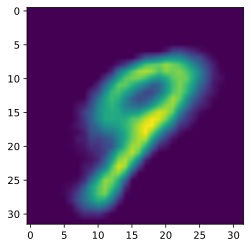

In [235]:
plt.imshow(y_[5][0].cpu().detach().numpy(),interpolation = 'bilinear')

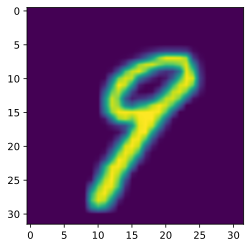

In [236]:
plt.imshow(x[5][0].cpu().detach().numpy(),interpolation = 'bilinear')

In [237]:
feature[5]

tensor([0.1135, 0.0046], device='cuda:4', grad_fn=<SelectBackward>)

In [238]:
clss[5]

tensor([2.0117e-09, 9.4100e-04, 7.4777e-12, 9.8422e-07, 7.3261e-01, 1.2552e-04,
        6.2659e-07, 2.3726e-01, 2.9063e-02, 1.1589e-19], device='cuda:4',
       grad_fn=<SelectBackward>)

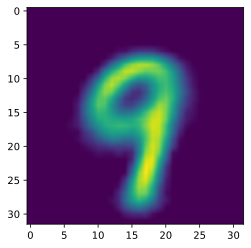

In [280]:
clss = torch.FloatTensor([[0,0,0,0,0,0,0,0,0,1]]).cuda(device)
feature = torch.FloatTensor([[0.5,0.1]]).cuda(device)

code = torch.hstack((clss,feature)).cuda(device)
test = ae1.decoder(code)
plt.imshow(test[0][0].cpu().detach().numpy(),interpolation = 'bilinear')

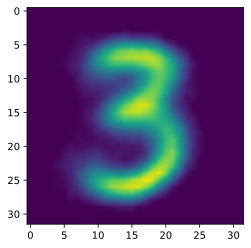

In [283]:
clss = torch.FloatTensor([[0,0,0,1,0,0,0,0,0,0]]).cuda(device)
feature = torch.FloatTensor([[0.5,0.1]]).cuda(device)

code = torch.hstack((clss,feature)).cuda(device)
test = ae1.decoder(code)
plt.imshow(test[0][0].cpu().detach().numpy(),interpolation = 'bilinear')

In [273]:
# torch.save(ae1,'model/AE/MNIST-AE1.pt')
# mymodel = torch.load('model/AE/MNIST-AE1.pt')

In [284]:
10*91+20*61

2130

In [286]:
logvar = torch.Tensor([[1,2,3]])
logvar

tensor([[1., 2., 3.]])

In [295]:
logvar.mul(0.5)

tensor([[0.5000, 1.0000, 1.5000]])

In [296]:
torch.exp(logvar.mul(0.5))

tensor([[1.6487, 2.7183, 4.4817]])